In [1]:
import matplotlib.pyplot as plt

import networkx as nx

from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from functools import partial
import pandas
from gerrychain.tree import recursive_tree_part

from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper

import geopandas as gpd

import os

from gerrychain.constraints.contiguity import contiguous_components, contiguous

from gerrychain.updaters import cut_edges

from gerrychain.tree import bipartition_tree, find_balanced_edge_cuts_memoization

#import maup

import numpy as np

import pandas as pd

import random

In [3]:
graph = Graph.from_json('AL_Processed_Precincts.json')
precincts = gpd.read_file('AL_Processed_Precincts.shp')

In [4]:
for node in graph.nodes():
    graph.nodes[node]["pp"] = graph.nodes[node]["G20PREDBID"]/(graph.nodes[node]["G20PREDBID"]+graph.nodes[node]["G20PRERTRU"]+1)

In [15]:
precincts['pp']= precincts['G20PREDBID']/(precincts['G20PREDBID']+ precincts['G20PRERTRU']+ 1)

(-88.65247604999999, -84.70899695, 29.901244849999998, 35.25120815)

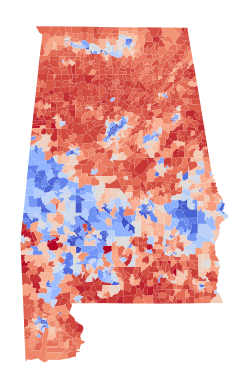

In [16]:
precincts.plot(column='pp',cmap='coolwarm_r')
plt.axis('off')

In [18]:
def county_splits(part):
  ad = dict(part.assignment)
  precincts['current'] = precincts['PRECINCTID'].map(ad)
  return sum(precincts.groupby('COUNTYFP')['current'].nunique() >1)

total_population = 0
for node in graph.nodes():
    total_population += graph.nodes()[node]['population']

my_updaters = {
    "population": updaters.Tally("population", alias="population"),
    "cut_edges": cut_edges,
    "PP":polsby_popper,
    "county_splits":county_splits
}


num_elections = 2



election_names = [
    "PRES",
    "BPOP",
]

election_columns = [
    ["G20PREDBID", "G20PRERTRU"],
    ["P0010004", "P0010003"],
]


elections = [
    Election(
        election_names[i],
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

my_updaters.update(election_updaters)

con_part = GeographicPartition(graph,recursive_tree_part(graph, range(7),total_population/7, "population", .02, 1),my_updaters)

In [23]:
graph.nodes["01001000001"]

{'boundary_node': False,
 'area': 0.01942094783500011,
 'GEOID20': '010010210001000',
 'STATEFP': '01',
 'COUNTYFP': '001',
 'VAP_MOD': 11,
 'CON': 5,
 'C_X': -86.84331901070445,
 'C_Y': 32.5923967364245,
 'population': 795,
 'G20PRERTRU': 248.99,
 'G20PREDBID': 182.95,
 'P0010003': 465,
 'P0010004': 285,
 'pp': 0.42257587656488194}

In [24]:
alabama_graph = graph

In [25]:
alabama_graph.number_of_nodes()

1972

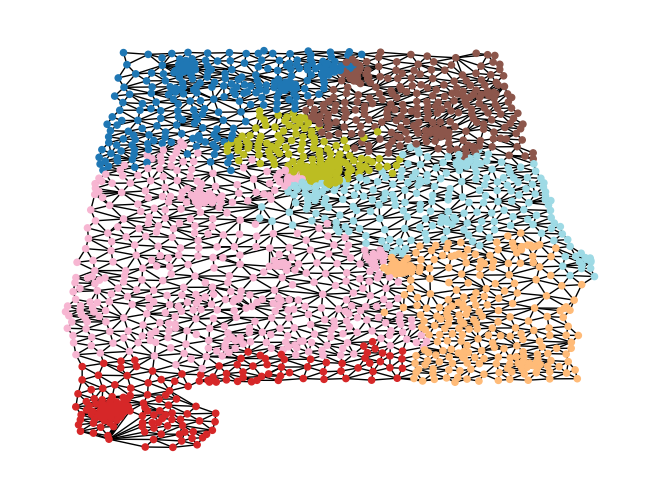

In [19]:
ad = dict(con_part.assignment)
nx.draw(graph,pos = {x:(graph.nodes[x]['C_X'],graph.nodes[x]['C_Y']) for x in graph.nodes()},
    node_size=20,node_color=[ad[x] for x in graph.nodes()],cmap='tab20')


In [29]:
import gymnasium as gym
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math


class RedistrictingEnv(gym.Env):
    def __init__(self):
        super(RedistrictingEnv, self).__init__()
        self.graph = self.process_data()
        self.num_partitions = 7 # there are only 7 congressional districts in alabama
        self.action_space = gym.spaces.Discrete(self.graph.number_of_nodes())
        self.observation_space = gym.spaces.Box(low=0, high=num_partitions-1, shape=(self.graph.number_of_nodes()), dtype=np.int32)

        self.initialize_partitions()
        self.pos = {(x, y): (y, -x) for x, y in self.grid_graph.nodes()}
        self.reset()
        
    def initialize_partitions(self):
        partition_size = self.grid_size * self.grid_size // self.num_partitions
        for i, node in enumerate(self.grid_graph.nodes()):
            self.grid_graph.nodes[node]['partition'] = i // partition_size

    def process_data(self):
        graph = Graph.from_json('AL_Processed_Precincts.json')
        precincts = gpd.read_file('AL_Processed_Precincts.shp')
        for node in graph.nodes():
            graph.nodes[node]["pp"] = graph.nodes[node]["G20PREDBID"]/(graph.nodes[node]["G20PREDBID"]+graph.nodes[node]["G20PRERTRU"]+1)
        
        precincts['pp']= precincts['G20PREDBID']/(precincts['G20PREDBID']+ precincts['G20PRERTRU']+ 1)
        
        return graph
    
    def step(self, action):
        # Convert action integer to grid coordinates
        x, y = action // self.grid_size, action % self.grid_size
        current_partition = self.grid_graph.nodes[(x, y)]['partition']
    
        # Prepare to switch to the next partition
        new_partition = (current_partition + 1) % self.num_partitions
    
        # Check if the action is valid (does not result in non-contiguous partitions)
        # Temporarily apply the action
        self.grid_graph.nodes[(x, y)]['partition'] = new_partition
        if not self.check_contiguity():
            # If not valid, revert the action and return a penalty
            self.grid_graph.nodes[(x, y)]['partition'] = current_partition
            reward = -1  # Penalty for non-contiguous partition
            done = True
        else:
            # If valid, keep the action and calculate reward
            compactness_scores = [self.calculate_polsby_popper(p) for p in range(self.num_partitions)]
            reward = (sum(compactness_scores) / len(compactness_scores))
            done = True

        # Prepare the new state to return
        state = np.array([[self.grid_graph.nodes[(i, j)]['partition'] for j in range(self.grid_size)] for i in range(self.grid_size)])
        return state, reward, done, {}


    def calculate_polsby_popper(self, partition):
        # Count the number of cells (area) and boundary edges (perimeter)
        area = sum(1 for _, node_data in self.grid_graph.nodes(data=True) if node_data['partition'] == partition)
        perimeter = 0
        for x, y in self.grid_graph.nodes():
            if self.grid_graph.nodes[(x, y)]['partition'] != partition:
                continue
            # Check all neighbors; if they are different or out of bounds, increase perimeter
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                nx, ny = x + dx, y + dy
                if (nx, ny) not in self.grid_graph or self.grid_graph.nodes[(nx, ny)]['partition'] != partition:
                    perimeter += 1

        if perimeter == 0:  # To avoid division by zero
            return 0

        polsby_popper = 4 * math.pi * area / perimeter**2
        return polsby_popper

    def check_contiguity(self):
        for p in range(self.num_partitions):
            partition_nodes = [n for n in self.grid_graph.nodes() if self.grid_graph.nodes[n]['partition'] == p]
            subgraph = self.grid_graph.subgraph(partition_nodes)
            if not nx.is_connected(subgraph):
                return False
        return True

    def reset(self):
        self.initialize_partitions()
        state = np.array([[self.grid_graph.nodes[(i, j)]['partition'] for j in range(self.grid_size)] for i in range(self.grid_size)])
        return state

    def render(self, mode='human'):
        partitions = [self.grid_graph.nodes[node]['partition'] for node in self.grid_graph.nodes()]
        cmap = ListedColormap(['red', 'blue', 'green', 'yellow', 'purple'][:self.num_partitions])  # Update for more colors
        nx.draw(self.grid_graph, pos=self.pos, node_color=partitions, cmap=cmap, with_labels=True)
        plt.show()

# Create and test the environment
env = RedistrictingEnv()
state = env.reset()
env.render()
for _ in range(10):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    env.render()
    if done:
        # print("Non-contiguous partition detected. Ending episode with penalty.")
        break


NameError: name 'num_partitions' is not defined